# Insider Trading - Python - SEC API

In [6]:
# Package used to execute HTTP POST request to the API
import json
import urllib.request

# API Key
TOKEN = '680419b0a91f14e780af14daaed5a8da02a12a9bb7b4f513b8f2430d9a2e3dc3'
# API endpoint
API = "https://api.sec-api.io?token=" + TOKEN

# Define the filter parameters
filter = "formType:\"4\" AND formType:(NOT \"N-4\") AND formType:(NOT \"4/A\") AND filedAt:[2019-07-01 TO 2019-08-01]"
# Start with the first filing. Increase it when paginating. 
# Set to 10000 if you want to fetch the next batch of filings. Set to 20000 for the next and so on.
start = 0
# Return 10,000 filings per API call
size = 10000
# Sort in descending order by filedAt
sort = [{ "filedAt": { "order": "desc" } }]

payload = {
  "query": { "query_string": { "query": filter } },
  "from": start,
  "size": size,
  "sort": sort
}

# Format your payload to JSON bytes
jsondata = json.dumps(payload)
jsondataasbytes = jsondata.encode('utf-8')   # needs to be bytes

# Instantiate the request 
req = urllib.request.Request(API)

# Set the correct HTTP header: Content-Type = application/json
req.add_header('Content-Type', 'application/json; charset=utf-8')
# Set the correct length of your request
req.add_header('Content-Length', len(jsondataasbytes))

# Send the request to the API
response = urllib.request.urlopen(req, jsondataasbytes)

# Read the response 
res_body = response.read()
# Transform the response into JSON
filingsJson = json.loads(res_body.decode("utf-8"))

In [7]:
# Print the response. Most likely this will throw an error because we fetched a
# large amount of data (10,000 filings). Reduce the number of filings and you will see a result here.
print(json.dumps(filingsJson, indent=2))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
# Show us how many filings matched our filter criteria. 
# This number is most likely different from the number of filings returned by the API.
print(filingsJson['total'])

26231


In [9]:
def compress_filings (filings):
    store = {}
    compressed_filings = []
    for filing in filings:
        filedAt = filing['filedAt']
        if filedAt in store and store[filedAt] < 5:
            compressed_filings.append(filing)
            store[filedAt] += 1
        elif filedAt not in store:
            compressed_filings.append(filing)
            store[filedAt] = 1
    return compressed_filings

In [10]:
filings = compress_filings(filingsJson['filings'])
filings

[{'cik': '1267926',
  'ticker': '',
  'companyName': 'MEDINI PAUL BENNETT',
  'formType': '4',
  'filedAt': '2019-08-01',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/1267926/0001209191-19-043944.txt',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/1267926/0001209191-19-043944-index.htm',
  'id': 'a1c2051da666db18516ceb51cd7ad87f'},
 {'cik': '1383283',
  'ticker': '',
  'companyName': 'Calcano Lawrence',
  'formType': '4',
  'filedAt': '2019-08-01',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/1383283/0001094891-19-000165.txt',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/1383283/0001094891-19-000165-index.htm',
  'id': '77c942bf51f2b8fbdcce3c6d56d597d4'},
 {'cik': '89439',
  'ticker': 'MLI',
  'companyName': 'MUELLER INDUSTRIES INC',
  'formType': '4',
  'filedAt': '2019-08-01',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/89439/0000089439-19-000080.txt',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/89439/0000089439-19

In [11]:
import xml.etree.ElementTree as ET
import re
import time

# Download the XML version of the filing. If it fails wait for 5, 10, 15, ... seconds and try again.
def download_xml (url, tries = 1):
    try: 
        response = urllib.request.urlopen(url)
    except:
        print('Something went wrong. Wait for 5 seconds and try again.', tries)
        if tries < 5:
            time.sleep(5 * tries)
            download_xml(url, tries + 1)
    else:     
        # decode the response into a string
        data = response.read().decode('utf-8')
        # set up the regular expression extractoer in order to get the relevant part of the filing
        matcher = re.compile('<\?xml.*ownershipDocument>', flags=re.MULTILINE|re.DOTALL)
        matches = matcher.search(data)
        # the first matching group is the extracted XML of interest
        xml = matches.group(0)
        # instantiate the XML object
        root = ET.fromstring(xml)
        print(url)
        return root 

In [12]:
# Calculate the total transaction amount in $ of a giving form 4 in XML
def calculate_transaction_amount (xml):
    total = 0
    
    if xml is None:
        return total
    
    nonDerivativeTransactions = xml.findall("./nonDerivativeTable/nonDerivativeTransaction")

    for t in nonDerivativeTransactions:
        # D for disposed or A for acquired
        action = t.find('./transactionAmounts/transactionAcquiredDisposedCode/value').text
        # number of shares disposed/acquired
        shares = t.find('./transactionAmounts/transactionShares/value').text
        # price
        priceRaw = t.find('./transactionAmounts/transactionPricePerShare/value')
        price = 0 if priceRaw is None else priceRaw.text
        # set prefix to -1 if derivatives were disposed. set prefix to 1 if derivates were acquired.
        prefix = -1 if action == 'D' else 1
        # calculate transaction amount in $
        amount = prefix * float(shares) * float(price)
        total += amount
    
    return round(total, 2)

In [13]:
# Test the calc function by using just one filing  
url = 'https://www.sec.gov/Archives/edgar/data/1592176/0000706688-19-000155.txt'    
xml = download_xml(url) 
amount = calculate_transaction_amount(xml)
amount

https://www.sec.gov/Archives/edgar/data/1592176/0000706688-19-000155.txt


-77996.0

In [14]:
# Download the XML for each filing
# Calculate the total transaction amount per filing
# Save the calculate transaction value to the filing dict with key 'nonDerivativeTransactions' 
def add_non_derivative_transaction_amounts ():
    for filing in filings:
        url = filing['linkToTxt']
        xml = download_xml(url)
        nonDerivativeTransactions = calculate_transaction_amount(xml)
        filing['nonDerivativeTransactions'] = nonDerivativeTransactions

In [15]:
# Running the function prints the URL of each filing fetched
add_non_derivative_transaction_amounts()

https://www.sec.gov/Archives/edgar/data/1267926/0001209191-19-043944.txt
https://www.sec.gov/Archives/edgar/data/1383283/0001094891-19-000165.txt
https://www.sec.gov/Archives/edgar/data/89439/0000089439-19-000080.txt
https://www.sec.gov/Archives/edgar/data/89439/0000089439-19-000082.txt
https://www.sec.gov/Archives/edgar/data/1776488/0001567619-19-015588.txt
https://www.sec.gov/Archives/edgar/data/89439/0000089439-19-000071.txt
https://www.sec.gov/Archives/edgar/data/899460/0001209191-19-043923.txt
https://www.sec.gov/Archives/edgar/data/899460/0001209191-19-043924.txt
https://www.sec.gov/Archives/edgar/data/899460/0001209191-19-043928.txt
https://www.sec.gov/Archives/edgar/data/1775610/0001764925-19-000048.txt
https://www.sec.gov/Archives/edgar/data/89439/0000089439-19-000069.txt
https://www.sec.gov/Archives/edgar/data/896264/0001179110-19-008903.txt
https://www.sec.gov/Archives/edgar/data/887936/0000887936-19-000079.txt
https://www.sec.gov/Archives/edgar/data/898437/0001171843-19-004

In [16]:
# Let's inspect filings and ensure that the new key 'nonDerivativeTransactions' is set
filings

[{'cik': '1267926',
  'ticker': '',
  'companyName': 'MEDINI PAUL BENNETT',
  'formType': '4',
  'filedAt': '2019-08-01',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/1267926/0001209191-19-043944.txt',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/1267926/0001209191-19-043944-index.htm',
  'id': 'a1c2051da666db18516ceb51cd7ad87f',
  'nonDerivativeTransactions': -326655.0},
 {'cik': '1383283',
  'ticker': '',
  'companyName': 'Calcano Lawrence',
  'formType': '4',
  'filedAt': '2019-08-01',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/1383283/0001094891-19-000165.txt',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/1383283/0001094891-19-000165-index.htm',
  'id': '77c942bf51f2b8fbdcce3c6d56d597d4',
  'nonDerivativeTransactions': 49850.0},
 {'cik': '89439',
  'ticker': 'MLI',
  'companyName': 'MUELLER INDUSTRIES INC',
  'formType': '4',
  'filedAt': '2019-08-01',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/89439/0000089439-19-000080.

# Preperation for plotting

We transform `filings` into a pandas dataframe with the following columns:
- filedAt
- type
- CIK
- ticker
- companyName
- linkToTxt
- linkToHtml
- nonDerivativeTransactions (previously added)


In [17]:
!pip install --user numpy
!pip install --user pandas
!pip install --user matplotlib

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pandas.io.json import json_normalize

In [19]:
filings = json_normalize(filings)
filings

,cik,ticker,companyName,formType,filedAt,linkToTxt,linkToHtml,id,nonDerivativeTransactions
0,1267926,,MEDINI PAUL BENNETT,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/126792...,https://www.sec.gov/Archives/edgar/data/126792...,a1c2051da666db18516ceb51cd7ad87f,-326655.00
1,1383283,,Calcano Lawrence,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/138328...,https://www.sec.gov/Archives/edgar/data/138328...,77c942bf51f2b8fbdcce3c6d56d597d4,49850.00
2,89439,MLI,MUELLER INDUSTRIES INC,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/89439/...,https://www.sec.gov/Archives/edgar/data/89439/...,1eefe8eae65256555d219519d8e2cfab,-11419.12
3,89439,MLI,MUELLER INDUSTRIES INC,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/89439/...,https://www.sec.gov/Archives/edgar/data/89439/...,a3ea978a129bc5b96bdbbf3c9e98cd17,-3006.63
4,1776488,,Collins James T.,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/177648...,https://www.sec.gov/Archives/edgar/data/177648...,031596b945aab29c38a55672e771b4aa,-16277.80
5,89439,MLI,MUELLER INDUSTRIES INC,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/89439/...,https://www.sec.gov/Archives/edgar/data/89439/...,0ed707d065507023ee552fcb35593a0c,-676480.93
6,899460,MNKD,MANNKIND CORP,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/899460...,https://www.sec.gov/Archives/edgar/data/899460...,5c11847656e633aff9bbbfd5f9652437,2032.05
7,899460,MNKD,MANNKIND CORP,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/899460...,https://www.sec.gov/Archives/edgar/data/899460...,3db502efebead39df29f573fbc65cbf5,4750.00
8,899460,MNKD,MANNKIND CORP,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/899460...,https://www.sec.gov/Archives/edgar/data/899460...,ec494a6368db58f8ff80e3941047a3c7,4750.00
9,1775610,,Butterfield Stewart,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/177561...,https://www.sec.gov/Archives/edgar/data/177561...,27e35024ecb3f2d3f4499b1d09fa59f0,-82959.50


In [21]:
def getBins (filings):
    bins = {}
    for index, row in filings.iterrows():
        filedAt = row['filedAt']
        nonDerivativeTransactions = row['nonDerivativeTransactions']
        value = bins[filedAt] + nonDerivativeTransactions if filedAt in bins else nonDerivativeTransactions
        bins[filedAt] = round(value, 2)
    return bins

In [22]:
bins = getBins(filings)
bins

{'2019-08-01': -307508.55,
 '2019-07-31': -747908.38,
 '2019-07-30': -1429658.3,
 '2019-07-29': -8225275.41,
 '2019-07-26': 1156979.0,
 '2019-07-25': -52570.2,
 '2019-07-24': 33714.05,
 '2019-07-23': -159310.41,
 '2019-07-22': 45017.99,
 '2019-07-19': 433572.94,
 '2019-07-18': -4480534.43,
 '2019-07-17': -45479.5}

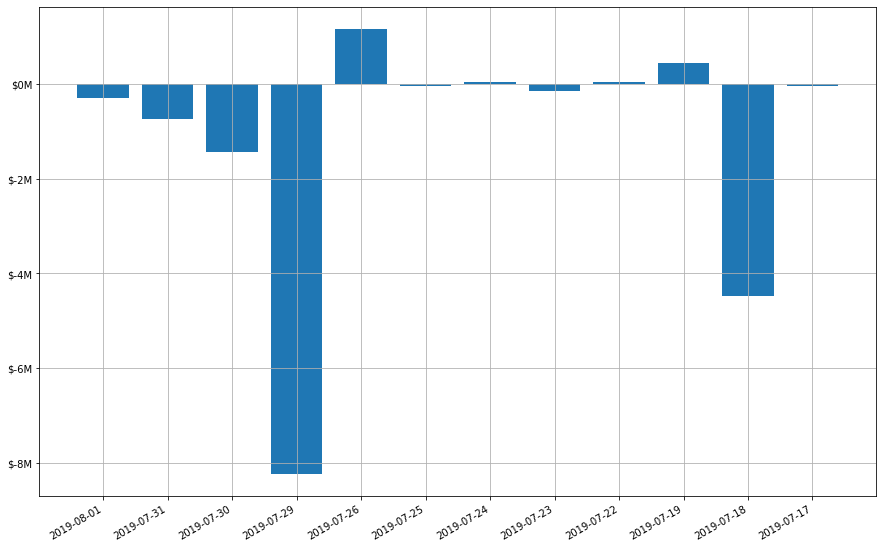

In [23]:
# Set size of figure
plt.rcParams['figure.figsize'] = [15, 10]

# Prettify y axis: 2000000 to $2M
def millions(x, pos):
    return '${:,.0f}M'.format(x*1e-6)

fig, ax = plt.subplots()
# Define bar plot
ax.bar(range(len(bins)), list(bins.values()), align='center')
ax.grid(True)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions))
# Prettify x axis
fig.autofmt_xdate()
# Set x axis values
plt.xticks(range(len(bins)), list(bins.keys()))
plt.show()